### COMP 6315
###  Edgar Acuna
###  Febrero del 2018
### Visualizacion de Missing Values

Varias de las funciones usadas en este notebooks fueron tomadas de Aleksey Bilogur https://github.com/ResidentMario
quien desarrollo una libreria missigno para visualizar missing values pero en Python 3. Aqui estamos usando Python 2.
Las dos funciones principales si son adaptaciones mias. las funciones se aplican a Census

In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Definiendo funciones auxiliares
def _ascending_sort(df):
    """
    Helper method for sorting.
    Returns a DataFrame whose values have been rearranged by ascending completeness.
    """
    return df.iloc[np.argsort(df.count(axis='columns').values), :]


def _descending_sort(df):
    """
    Helper method for sorting.
    Returns a DataFrame whose values have been rearranged by descending completeness.
    """
    return df.iloc[np.flipud(np.argsort(df.count(axis='columns').values)), :]


def nullity_sort(df, sort=None):
    """
    Sorts a DataFrame according to its nullity, in either ascending or descending order.

    :param df: The DataFrame object being sorted.
    :param sort: The sorting method: either "ascending", "descending", or None (default).
    :return: The nullity-sorted DataFrame.
    """
    _df = df
    if sort == "ascending":
        _df = _ascending_sort(df)
    elif sort == "descending":
        _df = _descending_sort(df)
    return _df


def _n_top_complete_filter(df, n):
    """
    Helper method for filtering a DataFrame.
    Returns the top n most populated entry columns.
    """
    return df.iloc[:, np.sort(np.argsort(df.count(axis='rows').values)[-n:])]


def _n_bottom_complete_filter(df, n):
    """
    Helper method for filtering a DataFrame.
    Returns the bottom n least populated entry columns.
    """
    return df.iloc[:, np.sort(np.argsort(df.count(axis='rows').values)[:n])]


def _p_top_complete_filter(df, p):
    """
    Helper method for filtering a DataFrame.
    Returns the entry columns which are at least p*100 percent completeness.
    """
    return df.iloc[:, [c >= p for c in df.count(axis='rows').values / len(df)]]


def _p_bottom_complete_filter(df, p):
    """
    Helper method for filtering a DataFrame.
    Returns the entry columns which are at most p*100 percent completeness.
    """
    return df.iloc[:, [c <= p for c in df.count(axis='rows').values / len(df)]]


def nullity_filter(df, filter=None, p=0, n=0):
    """
    Filters a DataFrame according to its nullity, using some combination of 'top' and 'bottom' numerical and
    percentage values. Percentages and numerical thresholds can be specified simultaneously: for example,
    to get a DataFrame with columns of at least 75% completeness but with no more than 5 columns, use
    `nullity_filter(df, filter='top', p=.75, n=5)`.

    :param df: The DataFrame whose columns are being filtered.
    :param filter: The orientation of the filter being applied to the DataFrame. One of, "top", "bottom",
    or None (default). The filter will simply return the DataFrame if you leave the filter argument unspecified or
    as None.
    :param p: A completeness ratio cut-off. If non-zero the filter will limit the DataFrame to columns with at least p
    completeness. Input should be in the range [0, 1].
    :param n: A numerical cut-off. If non-zero no more than this number of columns will be returned.
    :return: The nullity-filtered `DataFrame`.
    """
    _df = df
    if filter == "top":
        if p:
            _df = _p_top_complete_filter(_df, p)
        if n:
            _df = _n_top_complete_filter(_df, n)
    elif filter == "bottom":
        if p:
            _df = _p_bottom_complete_filter(_df, p)
        if n:
            _df = _n_bottom_complete_filter(_df, n)
    return _df




In [3]:
# Esta funcion hace una grafica de barras por cada atributo para mostrar la cantidad de datos completos
def bar_miss(df, figsize=(24, 10), fontsize=16, labels=None, color=(0.25, 0.25, 0.25), inline=True,
        filter=None, n=0, p=0, sort=None):
    """
    Plots a bar chart of the number of no-misssings by column.

    :param df: The DataFrame whose completeness is being nullity matrix mapped.
    :param log: Whether or not to display a logorithmic plot. Defaults to False (linear).
    :param filter: The filter to apply to the heatmap. Should be one of "top", "bottom", or None (default). See
    `nullity_filter()` for more information.
    :param n: The cap on the number of columns to include in the filtered DataFrame. See  `nullity_filter()` for
    more information.
    :param p: The cap on the percentage fill of the columns in the filtered DataFrame. See  `nullity_filter()` for
    more information.
    :param sort: The sort to apply to the heatmap. Should be one of "ascending", "descending", or None. See
    `nullity_sort()` for more information.
    :param figsize: The size of the figure to display. This is a `matplotlib` parameter. Defaults to (24,
    10).
    :param fontsize: The figure's font size. This default to 16.
    :param labels: Whether or not to display the column names. Would need to be turned off on particularly large
    displays. Defaults to True.
    :param color: The color of the filled columns. Default is a medium dark gray: the RGB multiple `(0.25, 0.25, 0.25)`.
    :return: If `inline` is True, the underlying `matplotlib.figure` object. Else, nothing.
    """
    # Get counts.
    nullity_counts = len(df) - df.isnull().sum()

    # Apply filters and sorts.
    df = nullity_filter(df, filter=filter, n=n, p=p)
    df = nullity_sort(df, sort=sort)

    # Create the basic plot.
    fig = plt.figure(figsize=figsize)
    (nullity_counts / len(df)).plot(kind='bar', figsize=figsize, fontsize=fontsize, color=color)

    # Get current axis.
    ax1 = plt.gca()

    # Start appending elements, starting with a modified bottom x axis.
    if labels or (labels is None and len(df.columns) <= 50):
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=fontsize)

        # Create the numerical ticks.
       # ax2 = ax1.twinx()
       # if not log:
            # Simple if the plot is ordinary.
        #    ax2.set_yticks(ax1.get_yticks())
         #   ax2.set_yticklabels([int(n*len(df)) for n in ax1.get_yticks()[0:-1]], fontsize=fontsize)
        #else:
            # For some reason when a logarithmic plot is specified `ax1` always contains two more ticks than actually
            # appears in the plot. For example, if we do `msno.histogram(collisions.sample(500), log=True)` the contents
            # of the naive `ax1.get_yticks()` is [1.00000000e-03, 1.00000000e-02, 1.00000000e-01, 1.00000000e+00,
            # 1.00000000e+01]. The fix is to ignore the first and last entries.
            #
            # Also note that when a log scale is used, we have to make it match the `ax1` layout ourselves.
         #   ax2.set_yscale('log')
          #  ax2.set_ylim(ax1.get_ylim())
           # ax2.set_yticks(ax1.get_yticks()[1:-1])
           # ax2.set_yticklabels([int(n*len(df)) for n in ax1.get_yticks()[1:-1]], fontsize=fontsize)

    # Creando el tercer eje, que muestra los totales de columnas en la parte superior.
    ax3 = ax1.twiny()
    ax3.set_xticks(ax1.get_xticks())
    ax3.set_xlim(ax1.get_xlim())
    ax3.set_xticklabels(nullity_counts.values, fontsize=fontsize, rotation=45, ha='left')
    ax3.grid(False)

    # Display.
    if inline:
        plt.show()
    else:
        return fig

In [4]:
# Esta funcion hace una grafica para mostrar la ubicacion de los missings values 
def image_miss(df,filter=None, n=0, p=0, sort=None, figsize=(25, 10),color=(0.25, 0.25, 0.25),
           fontsize=16, labels=None, inline=True,freq=None):
    """
    Presents a `matplotlib` matrix visualization of the missing values  of the given DataFrame.

    Note that for the default `figsize` 250 is a soft display limit.

    The default vertical display will fit up to 50 columns. If more than 50 columns are specified and the labels
    parameter is left unspecified the visualization will automatically drop the labels as they will not be very
    readable. You can override this behavior using `labels=True` and your own `fontsize` parameter.

    :param df: The DataFrame whose completeness is being nullity matrix mapped.
    :param filter: The filter to apply to the heatmap. Should be one of "top", "bottom", or None (default). See
    `nullity_filter()` for more information.
    :param n: The cap on the number of columns to include in the filtered DataFrame. See  `nullity_filter()` for
    more information.
    :param p: The cap on the percentage fill of the columns in the filtered DataFrame. See  `nullity_filter()` for
    more information.
    :param sort: The sort to apply to the heatmap. Should be one of "ascending", "descending", or None. See
    `nullity_sort()` for more information.
    :param figsize: The size of the figure to display. This is a `matplotlib` parameter.
    For the vertical configuration this defaults to (20, 10); the horizontal configuration computes a sliding value
    by default based on the number of columns that need to be displayed.
    :param fontsize: The figure's font size. This default to 16.
    :param labels: Whether or not to display the column names. Would need to be turned off on particularly large
    displays. Defaults to True. 
    :param color: The color of the filled columns. Default is a medium dark gray: the RGB multiple `(0.25, 0.25, 0.25)`.
    :return: If `inline` is True, the underlying `matplotlib.figure` object. Else, nothing.
    """

    # Apply filters and sorts.
    df = nullity_filter(df, filter=filter, n=n, p=p)
    df = nullity_sort(df, sort=sort)

    height = df.shape[0]
    width = df.shape[1]

    # z is the color-mask array.
    z = df.notnull().values

    # g is a NxNx3 matrix
    g = np.zeros((height, width, 3))

    # Apply the z color-mask to set the RGB of each pixel.
    g[z < 0.5] = [1, 1, 1]
    g[z > 0.5] = color

    # Set up the matplotlib grid layout.
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(1, 1)
    ax0 = plt.subplot(gs[0])

    # Create the nullity plot.
    ax0.imshow(g, interpolation='none')

    # Remove extraneous default visual elements.
    ax0.set_aspect('auto')
    ax0.grid(b=False)
    ax0.xaxis.tick_top()
    ax0.xaxis.set_ticks_position('none')
    ax0.yaxis.set_ticks_position('none')
    ax0.spines['top'].set_visible(False)
    ax0.spines['right'].set_visible(False)
    ax0.spines['bottom'].set_visible(False)
    ax0.spines['left'].set_visible(False)

    # Set up and rotate the column ticks.
    # The labels argument is set to None by default. If the user specifies it in the argument,
    # respect that specification. Otherwise display for <= 50 columns and do not display for > 50.
    if labels or (labels is None and len(df.columns) <= 50):
        ha = 'left'
        ax0.set_xticks(list(range(0, width)))
        ax0.set_xticklabels(list(df.columns), rotation=45, ha=ha, fontsize=fontsize)
    else:
        ax0.set_xticks([])

    # Adds Timestamps ticks if freq is not None,
    # else sets up the two top-bottom row ticks.
    if freq:
        ts_list = []

        if type(df.index) == pd.PeriodIndex:
            ts_array = pd.date_range(df.index.to_timestamp().date[0],
                                     df.index.to_timestamp().date[-1],
                                     freq=freq).values

            ts_ticks = pd.date_range(df.index.to_timestamp().date[0],
                                     df.index.to_timestamp().date[-1],
                                     freq=freq).map(lambda t:
                                                    t.strftime('%Y-%m-%d'))

        elif type(df.index) == pd.tseries.index.DatetimeIndex:
            ts_array = pd.date_range(df.index.date[0], df.index.date[-1],
                                     freq=freq).values

            ts_ticks = pd.date_range(df.index.date[0], df.index.date[-1],
                                     freq=freq).map(lambda t:
                                                    t.strftime('%Y-%m-%d'))
        else:
            raise KeyError("Dataframe index must be PeriodIndex or DatetimeIndex.")
        try:
            for value in ts_array:
                ts_list.append(df.index.get_loc(value))
        except KeyError:
            raise KeyError("Could not divide time index into desired frequency.")

        ax0.set_yticks(ts_list)
        ax0.set_yticklabels(ts_ticks, fontsize=20, rotation=0)
    else:
        ax0.set_yticks([0, df.shape[0] - 1])
        ax0.set_yticklabels([1, df.shape[0]], fontsize=20, rotation=0)

    # Create the inter-column vertical grid.
    in_between_point = [x + 0.5 for x in range(0, width - 1)]
    for in_between_point in in_between_point:
        ax0.axvline(in_between_point, linestyle='-', color='white')

    
    # Plot if inline, return the figure if not.
    if inline:
        plt.show()
    else:
        return fig




In [5]:
#Leyendo la base de datos census de la internet
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', 
    header=None, 
    sep=',',na_values=[' ?'])

df.columns=['v1', 'v2', 'v3', 'v4', 'v5','v6','v7','v8','v9','v10','v11','v12','v13','v14','class']

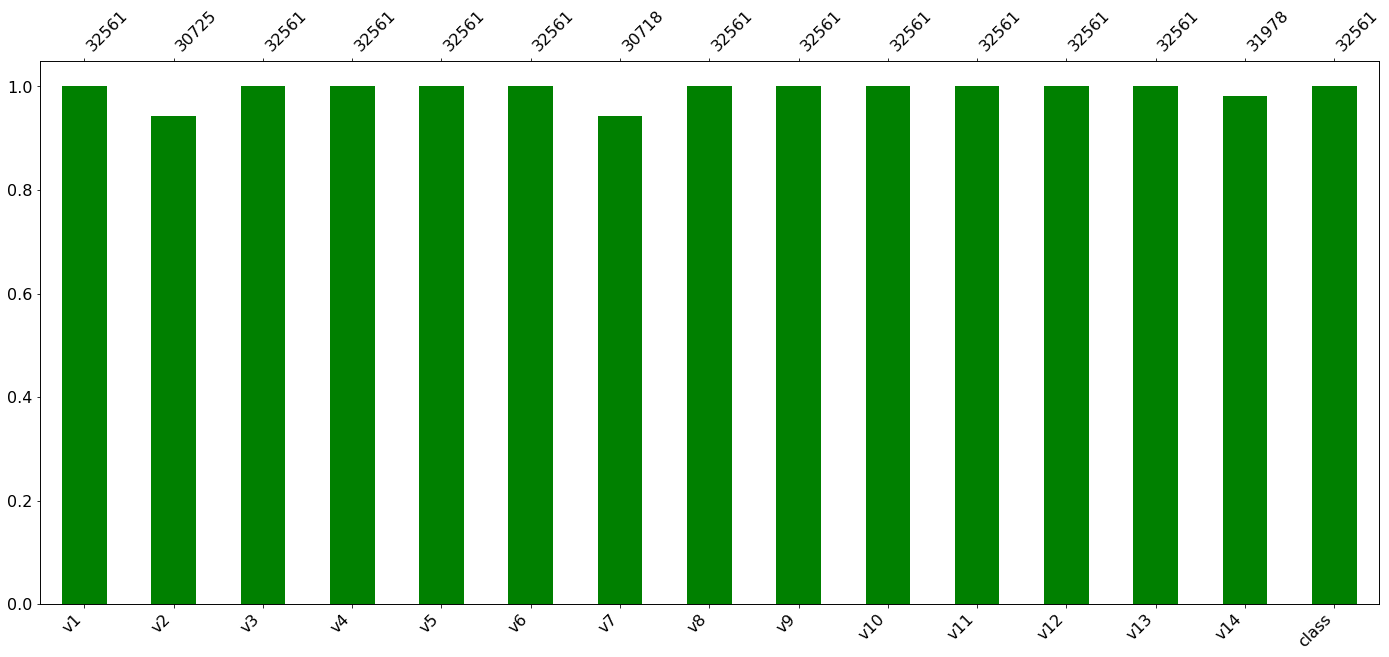

In [6]:
bar_miss(df,color="Green")

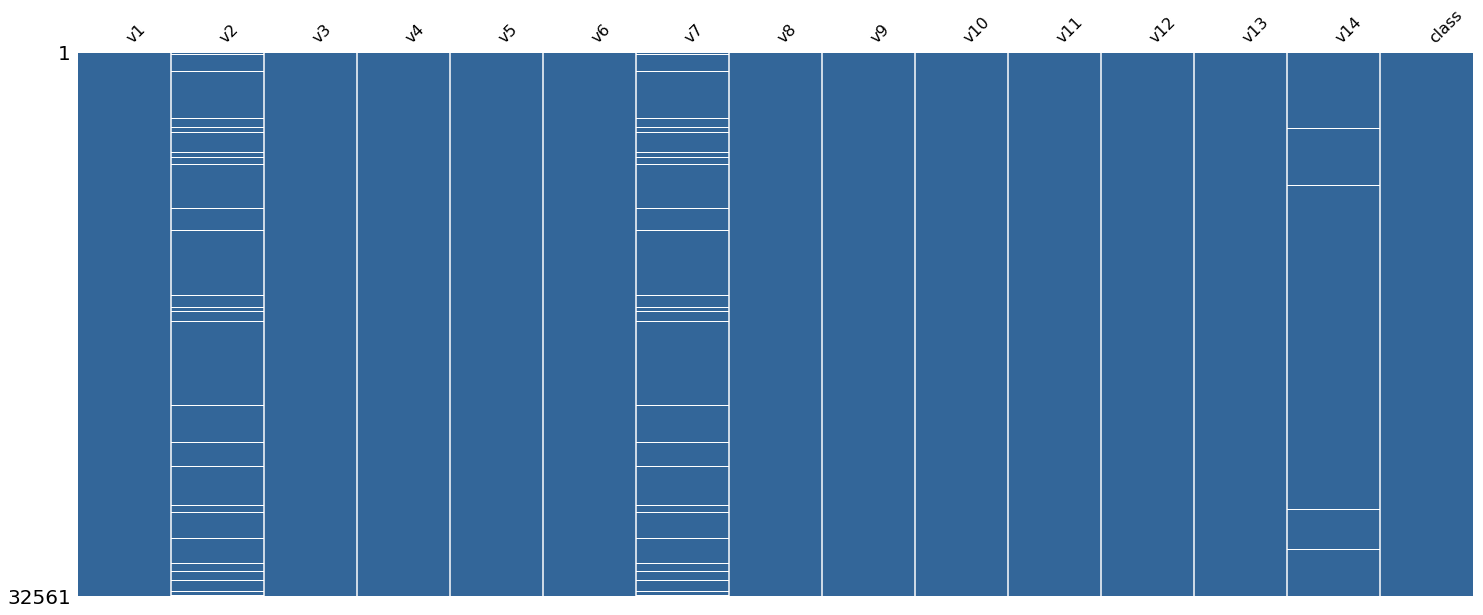

In [7]:
image_miss(df,color=(.2,.4,.6))